In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from silentsub.problem import SilentSubstitutionProblem
from silentsub.CIE import get_CIES026

In [2]:
# Functions for waveform
def get_time_vector(duration):
    t = np.arange(0, (duration*1000), 10).astype("int")
    return t


def sinusoid_modulation(f, duration, Fs=50):
    x = np.arange(duration * Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm


def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm*amplitude)).astype("int")
    return ivals

In [3]:
# Set up calibration data
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led', 'intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'
spds = spds.sort_index()
spds

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

ss = SilentSubstitutionProblem(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1,
    isolate=['I'],
    silence=['M', 'L', 'S']
    )

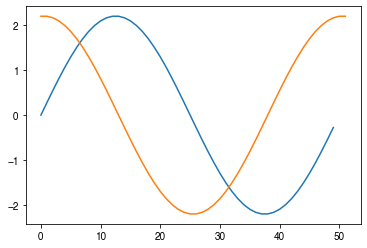

In [4]:
# Target contrast vals for modulation
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * 2.2
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

S-cone contrast modulation
==========================

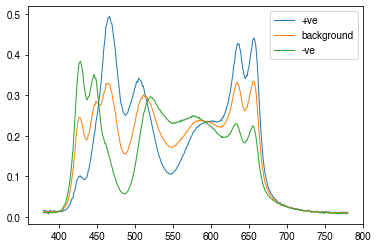

In [5]:


# Background is all channels at half power
bg_settings = np.array([.5]*10)

# Calcualte modulation spectra for S-cone modulation
contrast_mods = [ss.pseudo_inverse_contrast(bg_settings, [0, 0, 0, tc]) for tc in target_contrasts]
spectra = [bg_settings + mod for mod in contrast_mods]

plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[0]), lw=1, label='+ve')
plt.plot(ss.predict_multiprimary_spd(bg_settings), lw=1, label='background')
plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[-1]), lw=1, label='-ve')
plt.legend()


Modulation peak
---------------

	(array([ 0.09512556]), array([-0.03637838, -0.028435  ,  0.00407446]), array([ 0.16658019]))
	Background luminance: 18248.091718337455
	Modulation luminance: 17685.65468203888
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.33328564  0.3202709 ]


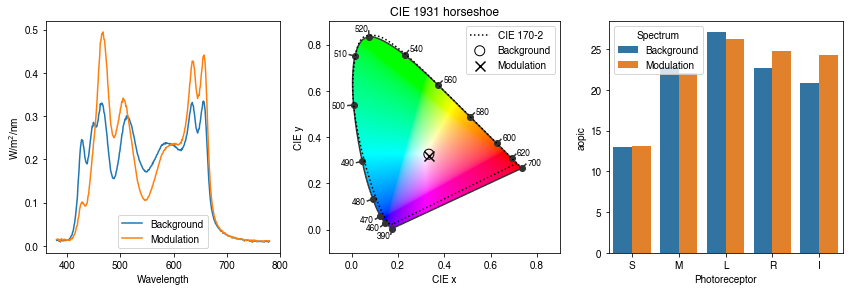

S-cone contrast: [ 0.16658019]
Splatter: [-0.03637838 -0.028435    0.00407446]


In [6]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[0]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[0]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Modulation trough
-----------------

	(array([-0.141111]), array([-0.00743312, -0.00838558, -0.01390945]), array([-0.20964714]))
	Background luminance: 18248.091718337455
	Modulation luminance: 18100.517106541432
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.33338648  0.32711669]


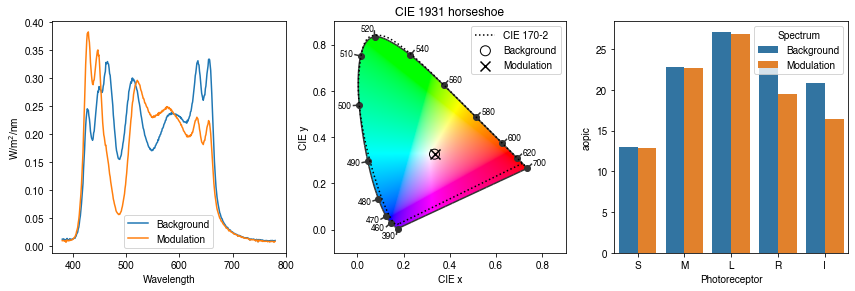

S-cone contrast: [-0.20964714]
Splatter: [-0.00743312 -0.00838558 -0.01390945]


In [7]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[-1]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[-1]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Contrast modulations
--------------------

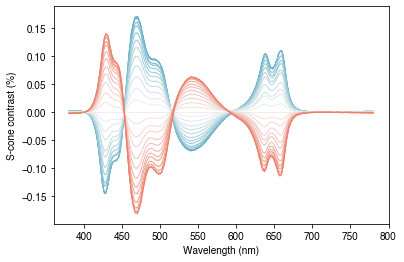

In [26]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ss.predict_multiprimary_spd(bg_settings)
for i, s in enumerate(contrast_mods):
    mod_spd = ss.predict_multiprimary_spd(bg_settings+s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');